# Clean dataset using influence functions and neural networks

A dataset usually consists of a lot of data points, while not all data points are equally important for achieving the desired accuracy. Sometimes it is necessary to speed up the gradient calculations or optimize the required RAM. Example applications are reinforcement learning or continuous optimal control tasks. This notebook

- shows how to calculate influences using the pyDVL library of an arbitrary (usually called training) set of data samples $X_\text{train} \subseteq \mathbb{R}^d$ onto a test set $X_\text{test} \subseteq \mathbb{R}^d$.
- shows a plot with the weighted F1-score on the y-axis and the number of samples on the x-axis.
- selects the optimal number of samples for the dataset as induced by the influence functions.

First, an arbitrary random dataset can be loaded or created using the ```utils.dataset.Dataset``` class. For showcase purposes the wine dataset is used. It can be loaded (as any other compatible dataset) directly from sklearn.

In [2]:
from sklearn.datasets import load_wine
from valuation.utils.dataset import Dataset

wine_bunch = load_wine(as_frame=True)
dataset = Dataset.from_sklearn(wine_bunch)

## Fit a neural network to the data

First, a 2-layer neural network is created and fitted with pyDVL. This can be achieved by the following code snippet. It creates a 2-layer neural network with 16 neurons in each hidden layer.

In [13]:
from copy import copy
import torch
from valuation.influence.model_wrappers import TorchNeuralNetwork, fit_torch_model
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.optim import Adam, lr_scheduler
import numpy as np

x_transformer = MinMaxScaler()

transformed_dataset = copy(dataset)
x_train = x_transformer.fit_transform(transformed_dataset.x_train)
transformed_dataset.x_train = torch.tensor(x_train, dtype=torch.float)
transformed_dataset.y_train = torch.tensor(transformed_dataset.y_train, dtype=torch.long)
x_test = x_transformer.transform(transformed_dataset.x_test)
transformed_dataset.y_test = torch.tensor(transformed_dataset.y_test, dtype=torch.long)
transformed_dataset.x_test = torch.tensor(x_test, dtype=torch.float)
feature_dimension = transformed_dataset.x_train.shape[1]
unique_classes = np.unique(np.concatenate((dataset.y_train, dataset.y_test)))
num_classes = len(unique_classes)
network_size = [16, 16]
num_epochs = 300
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nn = TorchNeuralNetwork(feature_dimension, num_classes, network_size)
nn.to(device)
optimizer = Adam(params=nn.parameters(), lr= 0.001, weight_decay= 0.001)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

fit_torch_model(
    model=nn,
    x=transformed_dataset.x_train,
    y=transformed_dataset.y_train,
    loss=F.cross_entropy,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    batch_size=16,
)

A short visual inspection yields that all labels of the test set are now classified correctly. This can be verified with the following

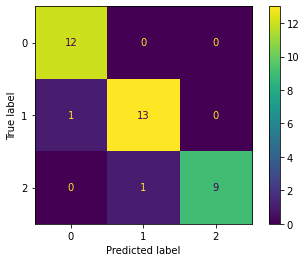

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_y_train = np.argmax(nn(transformed_dataset.x_train).detach(), axis=1)
pred_y_test = np.argmax(nn(transformed_dataset.x_test).detach(), axis=1)

cm = confusion_matrix(dataset.y_test, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

As one can see the accuracy is very close to 100% for the selected model.

## Calculating influences for small neural networks

The following section elaborates the calculation of influences through a neural network. It is noteworthy that the full Hessian matrix is constructed and used for inverting the gradients. This can only be achieved for small networks. In the case of a big network additionally conjugate gradient has to be used to perform approximate inversion. The influences for both the train and test set are calculated

In [15]:
from valuation.influence.general import influences

inversion_method = "direct" # cg for big networks

#test_influences = influences(model, transformed_dataset.x_test, transformed_dataset.y_test, inversion_method=inversion_method)
train_influences = influences(nn, F.cross_entropy, transformed_dataset, inversion_method=inversion_method)

by the preceding code snippet. Subsequently, the mean absolute influence of one train sample onto all test samples is calculated by

In [16]:
mean_influences = lambda arr: np.mean(np.abs(arr), axis=0)
mean_train_influences = mean_influences(train_influences)
# mean_test_influences = mean_influences(test_influences)

In [17]:
len(transformed_dataset.y_test)

36

In [18]:
train_influences.shape

(36, 142)

a visual inspection yields that there are indeed different influential samples.

## Keeping the most influential samples

Using the pyDVL library, the next section selects the most influential samples and retrains the model using the shortened dataset. This is done over the number of samples to showcase how the weighted F1-score changes.

In [28]:
from IPython.core.display_functions import display
from sklearn.metrics import f1_score
import pandas as pd

num_estimates_per_samples = 5
min_num_samples = 1
metrics = {}
x_range = range(min_num_samples, len(dataset), 5)

for i, num_shortened_samples in enumerate(x_range):
    display(f"Iteration {i+1}/{len(x_range)}")
    summed_metric = 0

    for j in range(num_estimates_per_samples):
        idx = np.argsort(mean_train_influences)[:num_shortened_samples]
        shortened_dataset = copy(transformed_dataset)
        shortened_dataset.x_train = shortened_dataset.x_train[idx]
        shortened_dataset.y_train = shortened_dataset.y_train[idx]
        shortened_nn = TorchNeuralNetwork(feature_dimension, num_classes, network_size)
        shortened_nn.to(device)
        optimizer = Adam(params=nn.parameters(), lr= 0.001, weight_decay= 0.001)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        fit_torch_model(
            model=nn,
            x=transformed_dataset.x_train,
            y=transformed_dataset.y_train,
            loss=F.cross_entropy,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=num_epochs,
            batch_size=32,
        )
        
        pred_y_test = np.argmax(shortened_nn(transformed_dataset.x_test).detach(), axis=1)
        summed_metric += f1_score(shortened_dataset.y_test, pred_y_test, average="weighted")

    metrics[num_shortened_samples] = summed_metric / num_estimates_per_samples

'Iteration 1/29'

'Iteration 2/29'

'Iteration 3/29'

'Iteration 4/29'

'Iteration 5/29'

KeyboardInterrupt: 

Note, how the model is created completely new and is not derived from the previous model. This section showcases how to use the influence calculations The notebook finishes by plotting

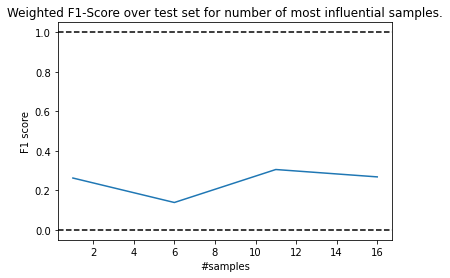

In [30]:
import matplotlib.pyplot as plt

plt.figure()
metrics = pd.Series(metrics)
metrics.plot(xlabel="#samples", ylabel="F1 score", title="Weighted F1-Score over test set for number of most influential samples.")
hline_kwargs = {
    "linestyle": "--",
    "color": "black"
}
plt.axhline(0.0, **hline_kwargs)
plt.axhline(1.0, **hline_kwargs)
plt.show()

the optimal number of samples on the x-axis along with the weighted F1-score on the y-axis.

In [31]:
optimal_number_of_samples = metrics.index[metrics.argmax()]
f"The optimal number of samples is {optimal_number_of_samples}"

'The optimal number of samples is 11'

Over multiple runs with different the optimal number of samples canges, but it can be said to be safe to remove around 30% of the samples of the wine dataset to easily achieve the same data accuracy.